In [1]:
import sys
sys.path.append('../')

import torch 
import torch.nn as nn 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from constant.models.classification import NN, CNN
from compute_ntk import get_ntk, get_fnet_single

DEVICE="cuda"

In [2]:
transform = Compose([
                    ToTensor(),
                    Normalize((0.1307,), (0.3081,))
                    ])

dataset = MNIST("../mnist/", download=True, train=True, transform=transform)

x_ntk = torch.stack([dataset[i][0] for i in range(20)]).to(DEVICE)

# Linear Model:

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Dim 50: mean pairwise NTK distance = 6350.5493
Dim 100: mean pairwise NTK distance = 4548.2866
Dim 500: mean pairwise NTK distance = 2253.2207
Dim 1000: mean pairwise NTK distance = 2067.7808
Dim 5000: mean pairwise NTK distance = 3055.3726
Dim 10000: mean pairwise NTK distance = 4008.0889


/tmp/ipykernel_18218/326232200.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)


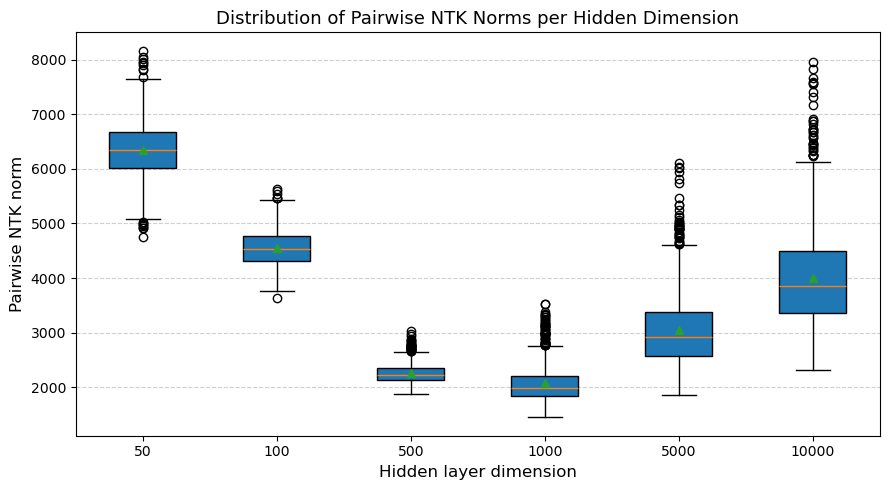

In [3]:
ITER=50

results_dict = {
    50:[[] for _ in range(ITER)],
    100:[[] for _ in range(ITER)],
    500:[[] for _ in range(ITER)],
    1_000:[[] for _ in range(ITER)],
    5_000:[[] for _ in range(ITER)],
    10_000:[[] for _ in range(ITER)],
}

pairwise_dists = {}  # store all distances per dim

for dim in results_dict.keys():

    ntk_vectors = []

    # Compute NTK vectors for each iteration
    for iter in range(ITER):
        model = NN(dim).to(DEVICE)
        parameters = {k: v.detach() for k, v in model.named_parameters()}
        fnet_single = get_fnet_single(model)

        ntk = get_ntk(fnet_single, parameters, x_ntk, multi=True)
        n = ntk.shape[0]
        idx = torch.triu_indices(n, n)
        ntk_flat = ntk[idx[0], idx[1]].cpu().numpy()

        ntk_vectors.append(ntk_flat)
        results_dict[dim][iter] = ntk_flat

    # Compute pairwise distances between all 50 flattened NTKs
    pairwise = []
    for i, j in combinations(range(ITER), 2):
        diff = ntk_vectors[i] - ntk_vectors[j]
        dist = np.linalg.norm(diff)
        pairwise.append(dist)

    pairwise_dists[dim] = np.array(pairwise)

# Print mean pairwise distance for each dimension
for dim, dists in pairwise_dists.items():
    print(f"Dim {dim}: mean pairwise NTK distance = {dists.mean():.4f}")

# ==========================
# 📊 Plot NTK pairwise distance distributions
# ==========================

dims = sorted(pairwise_dists.keys())
data = [pairwise_dists[dim] for dim in dims]

plt.figure(figsize=(9, 5))
plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)

plt.xlabel("Hidden layer dimension", fontsize=12)
plt.ylabel("Pairwise NTK norm", fontsize=12)
plt.title("Distribution of Pairwise NTK Norms per Hidden Dimension", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Convolutional Model:

Dim 16: mean pairwise NTK distance = 63587.4102
Dim 32: mean pairwise NTK distance = 79177.4531
Dim 64: mean pairwise NTK distance = 131441.8438
Dim 128: mean pairwise NTK distance = 159033.2188
Dim 256: mean pairwise NTK distance = 211861.4844


/tmp/ipykernel_18218/2787836721.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)


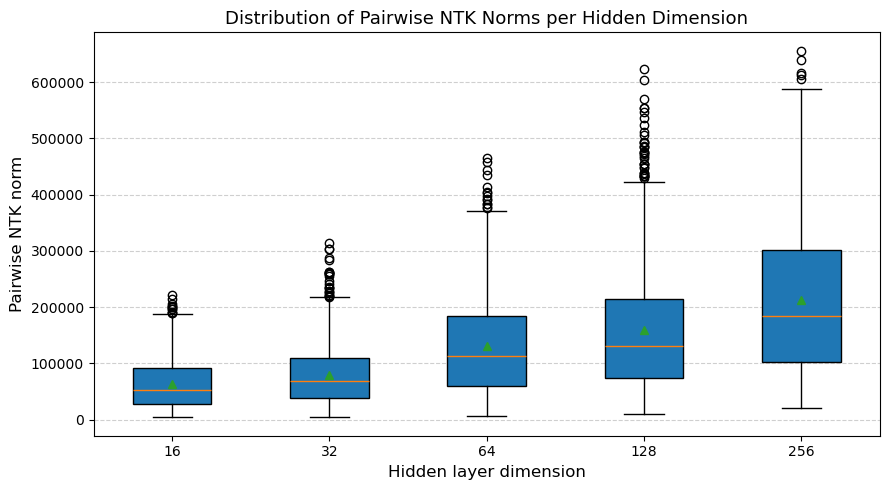

In [4]:
ITER=50

results_dict = {
    16:[[0] for _ in range(ITER)],
    32:[[0] for _ in range(ITER)],
    64:[[0] for _ in range(ITER)],
    128:[[0] for _ in range(ITER)],
    256:[[0] for _ in range(ITER)],
}

pairwise_dists = {}  # store all distances per dim

for dim in results_dict.keys():

    ntk_vectors = []

    # Compute NTK vectors for each iteration
    for iter in range(ITER):
        model = CNN(dim).to(DEVICE)
        parameters = {k: v.detach() for k, v in model.named_parameters()}
        fnet_single = get_fnet_single(model)

        ntk = get_ntk(fnet_single, parameters, x_ntk, multi=True)
        n = ntk.shape[0]
        idx = torch.triu_indices(n, n)
        ntk_flat = ntk[idx[0], idx[1]].cpu().numpy()

        ntk_vectors.append(ntk_flat)
        results_dict[dim][iter] = ntk_flat

    # Compute pairwise distances between all 50 flattened NTKs
    pairwise = []
    for i, j in combinations(range(ITER), 2):
        diff = ntk_vectors[i] - ntk_vectors[j]
        dist = np.linalg.norm(diff)
        pairwise.append(dist)

    pairwise_dists[dim] = np.array(pairwise)

# Print mean pairwise distance for each dimension
for dim, dists in pairwise_dists.items():
    print(f"Dim {dim}: mean pairwise NTK distance = {dists.mean():.4f}")

# ==========================
# 📊 Plot NTK pairwise distance distributions
# ==========================

dims = sorted(pairwise_dists.keys())
data = [pairwise_dists[dim] for dim in dims]

plt.figure(figsize=(9, 5))
plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)

plt.xlabel("Hidden layer dimension", fontsize=12)
plt.ylabel("Pairwise NTK norm", fontsize=12)
plt.title("Distribution of Pairwise NTK Norms per Hidden Dimension", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()